In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler

Пример, похоже, отсюда: https://www.kaggle.com/code/ssismasterchief/airline-passengers-prediction-lstm-keras

In [2]:
passengers = pd.read_csv("airline-passengers.csv")
passengers.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


<AxesSubplot:xlabel='Month'>

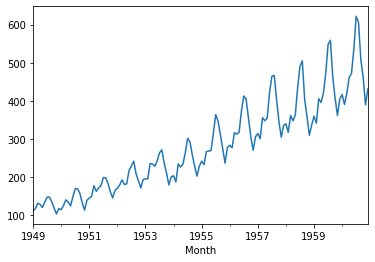

In [6]:
ds = pd.Series(data=passengers["Passengers"].values, index=pd.to_datetime(passengers["Month"]))
ds.plot()
# восходящий тренд и, возможно, сезонность

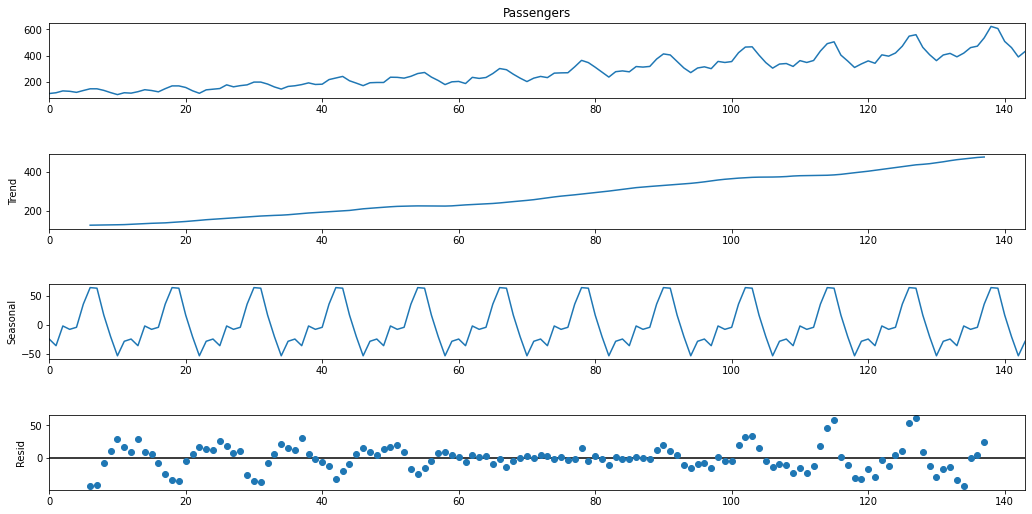

In [11]:
decompose = seasonal_decompose(passengers["Passengers"], model='additive', period=12)
fig = decompose.plot()
fig.set_figheight(8)
fig.set_figwidth(16)
plt.show()

In [12]:
dftest = adfuller(passengers["Passengers"], autolag='AIC', regression='ct')
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'], dftest))

{'adf': -2.1007818138446726,
 'pvalue': 0.5456589343124535,
 'usedlag': 13,
 'nobs': 130,
 'criticalvalues': {'1%': -4.030152423759672,
  '5%': -3.444817634956759,
  '10%': -3.1471816659080565},
 'icbest': 993.2814778200581}

In [13]:
dftest = adfuller(passengers["Passengers"].diff().dropna(), autolag='AIC', regression='ct')
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'], dftest))

{'adf': -3.0017868006677952,
 'pvalue': 0.13158212232605293,
 'usedlag': 12,
 'nobs': 130,
 'criticalvalues': {'1%': -4.030152423759672,
  '5%': -3.444817634956759,
  '10%': -3.1471816659080565},
 'icbest': 989.4227055888691}

In [15]:
dftest = adfuller(passengers["Passengers"].diff().diff().dropna(), autolag='AIC', regression='ct')
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'], dftest))

{'adf': -16.32725091069275,
 'pvalue': 0.0,
 'usedlag': 11,
 'nobs': 130,
 'criticalvalues': {'1%': -4.030152423759672,
  '5%': -3.444817634956759,
  '10%': -3.1471816659080565},
 'icbest': 990.3467007163898}

Правильнее, даже с RNN, учиться на стационарных данных (где статистики не меняются во времени; при нестационарности - то есть на изменение величины), но для простоты опутим этот шаг, так как для нейро-сетей это не так критично

<AxesSubplot:title={'center':'Number of passengers moving average'}>

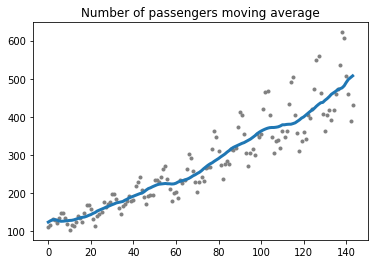

In [18]:
moving_average = passengers["Passengers"].rolling(
    window=12,      
    center=True,      
    min_periods=6,  
).mean()              

ax = passengers["Passengers"].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Number of passengers moving average", legend=False,
)

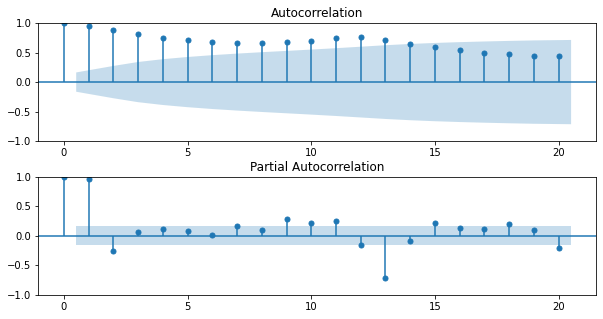

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
fig = plot_acf(passengers["Passengers"], lags=20, ax=ax[0])
fig = plot_pacf(passengers["Passengers"], lags=20, ax=ax[1])
plt.subplots_adjust(hspace=0.3)
plt.show()

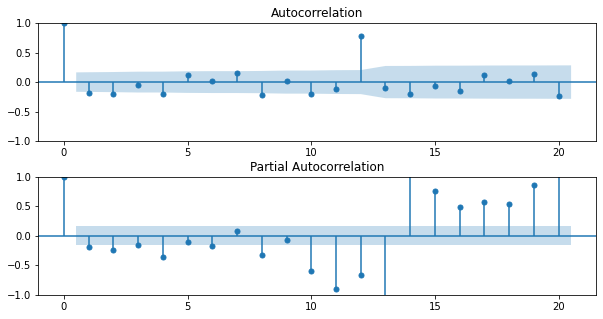

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
fig = plot_acf(passengers["Passengers"].diff().diff().dropna(), lags=20, ax=ax[0])
fig = plot_pacf(passengers["Passengers"].diff().diff().dropna(), lags=20, ax=ax[1])
plt.subplots_adjust(hspace=0.3)
plt.show()

**Predictions**

Далее предсказания будем строить только на один шаг вперед

In [3]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    """ создать набор данных с количеством шагов более 1 """
    X, y = [], []
    start += window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicesy = range(i+1, i+horizon+1)
        y.append(target[indicesy])
    return np.array(X), np.array(y)

def correlate(a, b):
    ma = a.mean()
    mb = b.mean()
    mab = (a*b).mean()
    sa = a.std()
    sb = b.std()

    val = 0
    if ((sa>0) & (sb>0)):
        val = (mab-ma*mb)/(sa*sb)
    return val

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX).astype(np.float32), np.array(dataY).astype(np.float32)

In [4]:
look_back = 1
horizon = 1 # predict one step in future
train_split = 115
batch_size = 1
buffer_size = 256

In [694]:
dataframe = pd.read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)  # leakage?

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

train_data = tf.data.Dataset.from_tensor_slices((trainX, trainY)).cache().shuffle(buffer_size).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((testX, testY)).batch(batch_size)

**Single LSTM**

In [647]:
# baseline: history 1, horizon 1, X[rows, history, features]
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(16, input_shape=(look_back, 1)),  # [time_steps, num_features]
    tf.keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="adam")
callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
            ]

history = model.fit(train_data, epochs=100, validation_data=test_data, callbacks=callbacks, verbose=0)

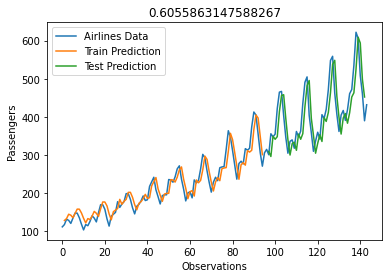

In [648]:
trainPredict = model.predict(trainX, verbose=0)
testPredict = model.predict(testX, verbose=0)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.title(f"{metrics.r2_score(testY.ravel(), testPredict.ravel())}")
plt.plot(scaler.inverse_transform(dataset), label="Airlines Data")
plt.plot(trainPredictPlot, label="Train Prediction")
plt.plot(testPredictPlot, label="Test Prediction")
plt.xlabel("Observations")
plt.ylabel("Passengers")
plt.legend()
plt.show()

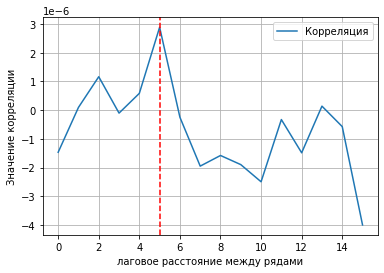

In [649]:
corr = []
start = 0 # начальная точка для проверки корреляций рядов
step = 15 # число точек для проверки корреляций рядов
h=0
yLen = testY.shape[0]
yValF = testY[start:start+step].flatten() # ряд истиных значений
yPredVal = testPredict[start:start+step] # ряд предсказаний 
# смотрим лаговые корреляции yValF[:-i], yPredVal[i:] для лагов от 0 до 5
for i in range(16):
    corr.append(correlate(yValF[:-1-i], testPredict[i:-1]))

plt.plot(corr,label = 'Корреляция')
plt.axvline(np.arange(16)[np.argmax(corr)], ls="--", c="r")
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.grid()
plt.legend()
plt.show()

**Double LSTM**

In [652]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(8, input_shape=(look_back,1), return_sequences=True),
    tf.keras.layers.LSTM(4),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="adam")
callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
            ]

history = model.fit(train_data, epochs=100, validation_data=test_data, callbacks=callbacks, verbose=0)

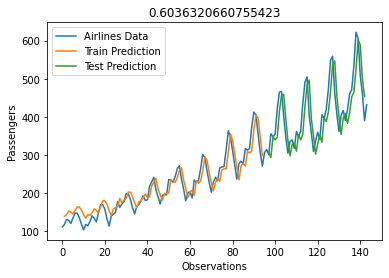

In [653]:
trainPredict = model.predict(trainX, verbose=0)
testPredict = model.predict(testX, verbose=0)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.title(f"{metrics.r2_score(testY.ravel(), testPredict.ravel())}")
plt.plot(scaler.inverse_transform(dataset), label="Airlines Data")
plt.plot(trainPredictPlot, label="Train Prediction")
plt.plot(testPredictPlot, label="Test Prediction")
plt.xlabel("Observations")
plt.ylabel("Passengers")
plt.legend()
plt.show()

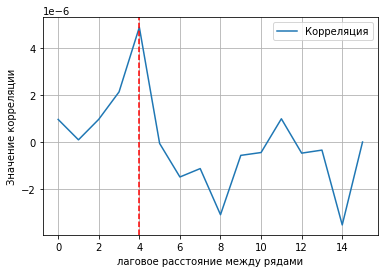

In [654]:
corr = []
start = 0
step = 15 
h=0
yLen = testY.shape[0]
yValF = testY[start:start+step].flatten() 
yPredVal = testPredict[start:start+step] 

for i in range(16):
    corr.append(correlate(yValF[:-1-i], testPredict[i:-1]))

plt.plot(corr,label = 'Корреляция')
plt.axvline(np.arange(16)[np.argmax(corr)], ls="--", c="r")
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.grid()
plt.legend()
plt.show()

**Single GRU**

In [656]:
model = tf.keras.Sequential([
    tf.keras.layers.GRU(16, input_shape=(look_back,1)),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="adam")
callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
            ]

history = model.fit(train_data, epochs=100, validation_data=test_data, callbacks=callbacks, verbose=0)

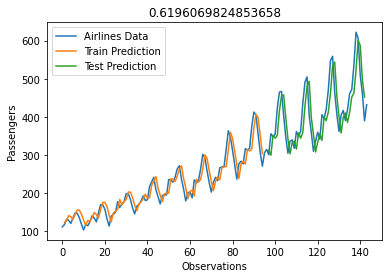

In [657]:
trainPredict = model.predict(trainX, verbose=0)
testPredict = model.predict(testX, verbose=0)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.title(f"{metrics.r2_score(testY.ravel(), testPredict.ravel())}")
plt.plot(scaler.inverse_transform(dataset), label="Airlines Data")
plt.plot(trainPredictPlot, label="Train Prediction")
plt.plot(testPredictPlot, label="Test Prediction")
plt.xlabel("Observations")
plt.ylabel("Passengers")
plt.legend()
plt.show()

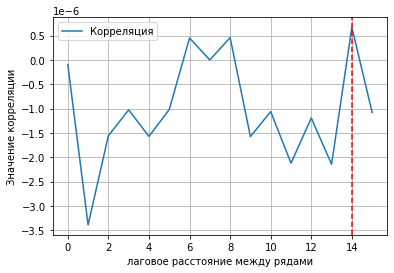

In [658]:
corr = []
start = 0 
step = 15 
h=0
yLen = testY.shape[0]
yValF = testY[start:start+step].flatten()
yPredVal = testPredict[start:start+step] 

for i in range(16):
    corr.append(correlate(yValF[:-1-i], testPredict[i:-1]))

plt.plot(corr,label = 'Корреляция')
plt.axvline(np.arange(16)[np.argmax(corr)], ls="--", c="r")
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.grid()
plt.legend()
plt.show()

**Convolutional**

In [660]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(8, input_shape=(look_back,1), return_sequences=True),
    tf.keras.layers.Conv1D(8, 3, strides=1, padding="same", activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="adam")
callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
            ]

history = model.fit(train_data, epochs=100, validation_data=test_data, callbacks=callbacks, verbose=0)

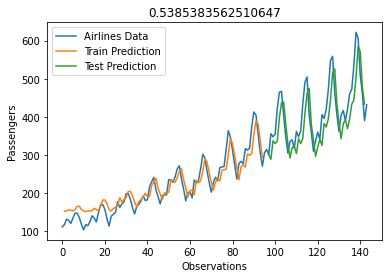

In [661]:
trainPredict = model.predict(trainX, verbose=0)
testPredict = model.predict(testX, verbose=0)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.title(f"{metrics.r2_score(testY.ravel(), testPredict.ravel())}")
plt.plot(scaler.inverse_transform(dataset), label="Airlines Data")
plt.plot(trainPredictPlot, label="Train Prediction")
plt.plot(testPredictPlot, label="Test Prediction")
plt.xlabel("Observations")
plt.ylabel("Passengers")
plt.legend()
plt.show()

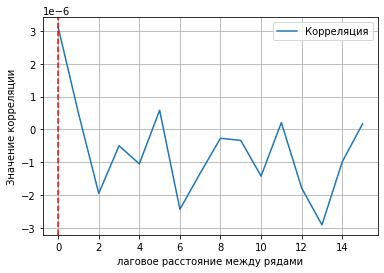

In [662]:
corr = []
start = 0 
step = 15 
h=0
yLen = testY.shape[0]
yValF = testY[start:start+step].flatten() 
yPredVal = testPredict[start:start+step] 

for i in range(16):
    corr.append(correlate(yValF[:-1-i], testPredict[i:-1]))

plt.plot(corr,label = 'Корреляция')
plt.axvline(np.arange(16)[np.argmax(corr)], ls="--", c="r")
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.grid()
plt.legend()
plt.show()

**AutoEncoder**

In [695]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(4, input_shape=(look_back, 1), return_sequences=False),
    tf.keras.layers.RepeatVector(1),
    tf.keras.layers.LSTM(4, input_shape=(look_back, 1), return_sequences=False),
    tf.keras.layers.Dense(1)
    # tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))  # horizon>1
])

model.compile(loss="mean_squared_error", optimizer="adam")
callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
            ]

history = model.fit(train_data, epochs=100, validation_data=test_data, callbacks=callbacks, verbose=0)

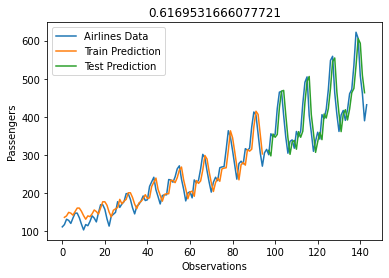

In [696]:
trainPredict = model.predict(trainX, verbose=0)
testPredict = model.predict(testX, verbose=0)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.title(f"{metrics.r2_score(testY.ravel(), testPredict.ravel())}")
plt.plot(scaler.inverse_transform(dataset), label="Airlines Data")
plt.plot(trainPredictPlot, label="Train Prediction")
plt.plot(testPredictPlot, label="Test Prediction")
plt.xlabel("Observations")
plt.ylabel("Passengers")
plt.legend()
plt.show()

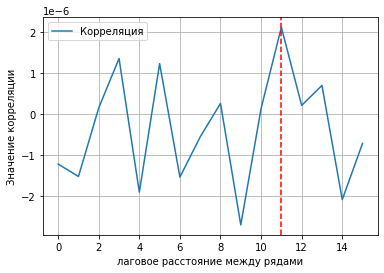

In [697]:
corr = []
start = 0 
step = 15 
h=0
yLen = testY.shape[0]
yValF = testY[start:start+step].flatten() 
yPredVal = testPredict[start:start+step] 

for i in range(16):
    corr.append(correlate(yValF[:-1-i], testPredict[i:-1]))

plt.plot(corr,label = 'Корреляция')
plt.axvline(np.arange(16)[np.argmax(corr)], ls="--", c="r")
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.grid()
plt.legend()
plt.show()

**Bidirectional**

In [668]:
model = tf.keras.Sequential([
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, input_shape=(look_back, 1), return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4, input_shape=(look_back, 1), return_sequences=False)),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="adam")
callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
            ]

history = model.fit(train_data, epochs=100, validation_data=test_data, callbacks=callbacks, verbose=0)

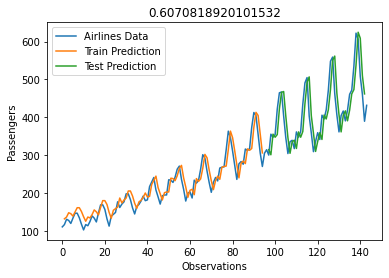

In [669]:
trainPredict = model.predict(trainX, verbose=0)
testPredict = model.predict(testX, verbose=0)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.title(f"{metrics.r2_score(testY.ravel(), testPredict.ravel())}")
plt.plot(scaler.inverse_transform(dataset), label="Airlines Data")
plt.plot(trainPredictPlot, label="Train Prediction")
plt.plot(testPredictPlot, label="Test Prediction")
plt.xlabel("Observations")
plt.ylabel("Passengers")
plt.legend()
plt.show()

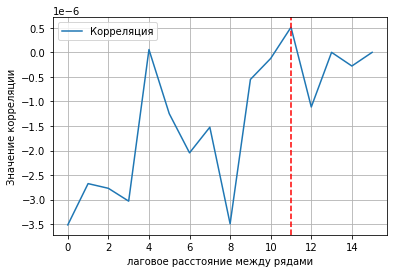

In [670]:
corr = []
start = 0 
step = 15 
h=0
yLen = testY.shape[0]
yValF = testY[start:start+step].flatten() 
yPredVal = testPredict[start:start+step] 

for i in range(16):
    corr.append(correlate(yValF[:-1-i], testPredict[i:-1]))

plt.plot(corr,label = 'Корреляция')
plt.axvline(np.arange(16)[np.argmax(corr)], ls="--", c="r")
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.grid()
plt.legend()
plt.show()

Можно провести еще множество экспериментов, в целом качество меняется не сильно от модели к модели, хотя по графикам видно, что отдельные модели имеют меньшее смещение относительно таргета. При этом количество лагов (look_back) при значениях от 1 до 3 отличаются не сильно (не отличаются). При увеличении до 5 качество падает.

In [5]:
def run(model, look_back=1):
    dataframe = pd.read_csv('airline-passengers.csv', usecols=[1], engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')

    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)  # leakage?

    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

    train_data = tf.data.Dataset.from_tensor_slices((trainX, trainY)).cache().shuffle(buffer_size).batch(batch_size)
    test_data = tf.data.Dataset.from_tensor_slices((testX, testY)).batch(batch_size)
    
    model.compile(loss="mean_squared_error", optimizer="adam")
    callbacks = [
                 tf.keras.callbacks.ReduceLROnPlateau(patience=3),
                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
                ]

    history = model.fit(train_data, epochs=100, validation_data=test_data, callbacks=callbacks, verbose=0)
    
    testPredict = model.predict(testX, verbose=0)

    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    
    score = metrics.r2_score(testY.ravel(), testPredict.ravel())
    
    return score

In [ ]:
from tqdm import trange

scores_m1, scores_m2 = np.array([]), np.array([])

for i in trange(50):
    model1 = tf.keras.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4, input_shape=(look_back, 1), return_sequences=False)),
        tf.keras.layers.Dense(1)
        ])
    model2 = tf.keras.Sequential([
        tf.keras.layers.LSTM(4, input_shape=(look_back,1), return_sequences=False),
        tf.keras.layers.RepeatVector(1),
        tf.keras.layers.LSTM(4, input_shape=(look_back,1), return_sequences=False),
        tf.keras.layers.Dense(1)
        ])
    score1 = run(model1)
    score2 = run(model2)

    scores_m1 = np.append(scores_m1, score1)
    scores_m2 = np.append(scores_m2, score2)

In [7]:
from scipy import stats

stats.ttest_rel(scores_m1, scores_m2)

Ttest_relResult(statistic=-1.4743245962421534, pvalue=0.146790493227282)

Модели не дают статистически различимых результатов (если полагаться только на коэффициент детерминации)

К вопросу о решении проблемы затухающих градиентов:

* Простой ответ: использовать слои с долгосрочной памятью (LSTM, GRU);
* Пробовать различные специфические способы инициализации весов;
* Попробовать сменить функцию активации (tanh), производная которой имеет более широкую область ненулевых (не близких к нулю) значений. Хотя, это может внести сумятицу в процесс оптимизации...